In [1]:
from datetime import datetime
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, SGDRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from planet.app import Planet
from parser.db import client

In [2]:
quacke_df: pd.DataFrame = client.query_df('SELECT * FROM quakes ORDER BY Date')
quacke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577034 entries, 0 to 577033
Data columns (total 60 columns):
 #   Column                  Non-Null Count   Dtype        
---  ------                  --------------   -----        
 0   Magnitude               577034 non-null  float64      
 1   Date                    577034 non-null  datetime64[s]
 2   Longitude               577034 non-null  float64      
 3   Latitude                577034 non-null  float64      
 4   Mercury_earth_distance  577034 non-null  float64      
 5   Mercury_sun_distance    577034 non-null  float64      
 6   Mercury_hlat            577034 non-null  float64      
 7   Mercury_hlon            577034 non-null  float64      
 8   Mercury_size            577034 non-null  float64      
 9   Mercury_radius          577034 non-null  float64      
 10  Mercury_a_ra            577034 non-null  float64      
 11  Mercury_elong           577034 non-null  float64      
 12  Venus_earth_distance    577034 non-null  flo

In [13]:
target_column = 'Magnitude'
y = quacke_df[target_column]
X = quacke_df.drop(['Magnitude', 'Date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def get_batch_param(X_train: pd.DataFrame, batch_size: int = 50000) -> tuple[int, int]:
    """"
    Return:
        batch_count, df_shape
    """
    dataset_shape = X_train.shape[0]    
    batch_count = dataset_shape // batch_size
    return batch_count, dataset_shape

In [19]:
def fit_with_batches(
        model,
        X: pd.DataFrame, 
        y: pd.DataFrame, 
        batch_size: int, 
        batch_count: int, 
        dataset_shape: int
    ):
    start = 0
    for step in range(batch_count):
        end = batch_size * (step + 1)
        if step == batch_count - 1:
            end = dataset_shape        
        print(start, end, step+1, batch_size)    
        model.fit(X.iloc[start:end], y.iloc[start:end])
        start = batch_size * (step + 1) + 1
    return model

In [20]:
batch_size = 50000
batch_count, dataset_shape = get_batch_param(X_train, batch_size)
batch_size, batch_count, dataset_shape

(50000, 9, 461627)

In [16]:
linear_model = Pipeline([('quad', PolynomialFeatures(degree=2)), ('lr', LinearRegression())])
linear_model = fit_with_batches(
    model=linear_model,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    batch_count=batch_count,
    dataset_shape=dataset_shape,
)

0 50000 1 50000
50001 100000 2 50000
100001 150000 3 50000
150001 200000 4 50000
200001 250000 5 50000
250001 300000 6 50000
300001 350000 7 50000
350001 400000 8 50000
400001 461627 9 50000


In [29]:
ridge_model = RidgeCV(alphas=(0.1, 1, 10), cv=20)
ridge_model = fit_with_batches(
    model=ridge_model,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    batch_count=batch_count,
    dataset_shape=dataset_shape,
)

0 50000 1 50000
50001 100000 2 50000
100001 150000 3 50000
150001 200000 4 50000
200001 250000 5 50000
250001 300000 6 50000
300001 350000 7 50000
350001 400000 8 50000
400001 461627 9 50000


In [30]:
lasso_model = LassoCV(cv=20)
lasso_model = fit_with_batches(
    model=lasso_model,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    batch_count=batch_count,
    dataset_shape=dataset_shape,
)

0 50000 1 50000
50001 100000 2 50000
100001 150000 3 50000
150001 200000 4 50000
200001 250000 5 50000
250001 300000 6 50000
300001 350000 7 50000
350001 400000 8 50000
400001 461627 9 50000


In [31]:
sgd_model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=200, tol=1e-3))
sgd_model = fit_with_batches(
    model=sgd_model,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    batch_count=batch_count,
    dataset_shape=dataset_shape,
)

0 50000 1 50000
50001 100000 2 50000
100001 150000 3 50000
150001 200000 4 50000
200001 250000 5 50000
250001 300000 6 50000
300001 350000 7 50000
350001 400000 8 50000
400001 461627 9 50000


### Расчет точности предсказаний

In [32]:
linear_score = cross_val_score(linear_model, X_test, y_test, cv=3)
ridge_score = ridge_model.score(X_test, y_test)
lasso_score = lasso_model.score(X_test, y_test)
sgd_score = sgd_model.score(X_test, y_test)

In [33]:
print(linear_score.mean(), ridge_score, lasso_score, sgd_score)

0.4614541341675357 0.40985460236737703 0.40539099409990564 0.40096247992285927


Линейная модель показывает хорошую точность только на имеющхся данных, будующие прогнозы крайне неточные (в том числе отрицательные значения)

In [34]:
y_lin = linear_model.predict(X_test)
y_ridge = ridge_model.predict(X_test)
y_lasso = lasso_model.predict(X_test)
y_sgd = sgd_model.predict(X_test)

x = np.arange(1, len(y_test)+1,1)[:100]
pic_y_lin = pd.Series(y_lin[:100]).set_axis(x)
pic_y_lasso = pd.Series(y_lasso[:100]).set_axis(x)
pic_y_test = y_test[:100].set_axis(x)
pic_y_ridge = pd.Series(y_ridge[:100]).set_axis(x)
pic_y_sgd = pd.Series(y_sgd[:100]).set_axis(x)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

med_ae = median_absolute_error(y_test, y_ridge)
mae = mean_absolute_error(y_test, y_ridge)
mse = mean_squared_error(y_test, y_ridge, squared=False)
cvs = cross_val_score(ridge_model, X_test, y_test, cv=3).mean() # вероятно этот показатель здесь не нужен, насколько я понимаю он применется на тренировочной или полной выборке
message = """Коэфициент детерминации - {0},\n
Средняя абсолютная ошибка - {1},\n
Среднее абсолютное отклонение - {2},\n
Среднеквадратичное отклонение - {3},\n
Перекрестная проверка - {4},\n 
""".format(ridge_score, med_ae, mae, mse, cvs)
print(message)

Коэфициент детерминации - 0.40985460236737703,

Средняя абсолютная ошибка - 0.40222567385650354,

Среднее абсолютное отклонение - 0.49646567976378475,

Среднеквадратичное отклонение - 0.6463881582126452,

Перекрестная проверка - 0.40980322230245614,
 



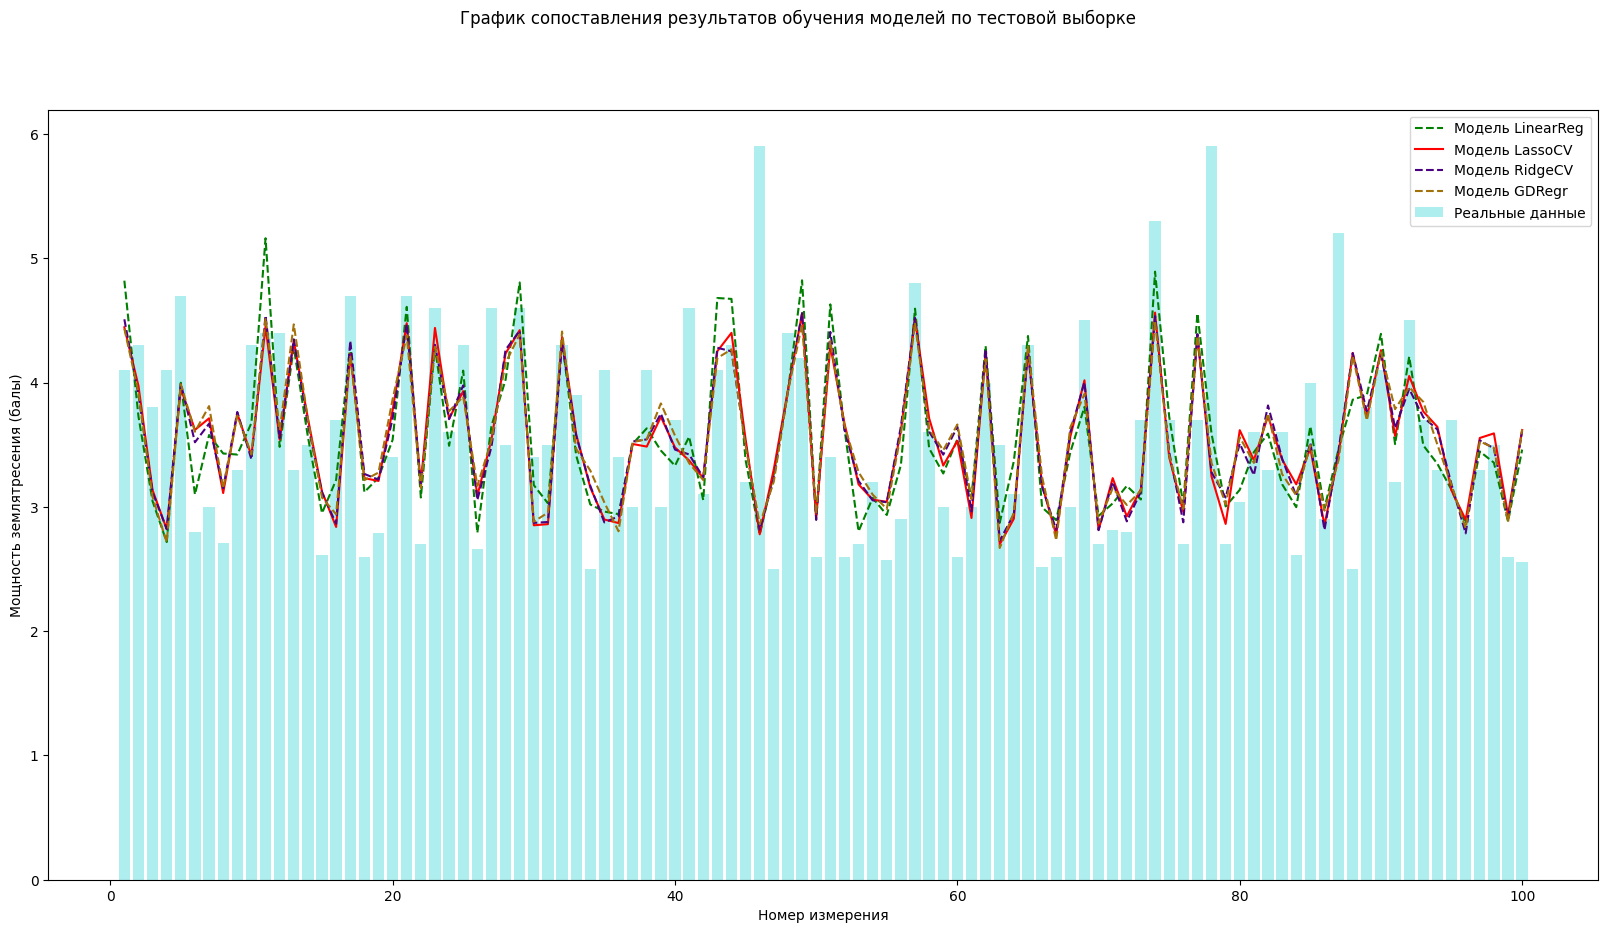

In [36]:
plt.figure(figsize=(20,10))
plt.suptitle('График сопоставления результатов обучения моделей по тестовой выборке')

plt.bar(x, pic_y_test,label='Реальные данные', color='#AFEEEE')
plt.plot(pic_y_lin, '--', color='g', label='Модель LinearReg')
plt.plot(pic_y_lasso, '-r', label='Модель LassoCV')
plt.plot(pic_y_ridge, '--', color='#4B0082', label='Модель RidgeCV')
plt.plot(pic_y_sgd, '--', color='#A27109', label='Модель GDRegr')

plt.xlabel('Номер измерения')
plt.ylabel('Мощность землятресения (балы)')
plt.legend(loc='best')

plt.show()

In [37]:
joblib.dump(linear_model, 'models/linear_model.pkl')
joblib.dump(ridge_model, 'models/ridge_model.pkl') 
joblib.dump(lasso_model, 'models/lasso_model.pkl')
joblib.dump(lasso_model, 'models/sgd_model.pkl')

['models/sgd_model.pkl']